# Model spotcheck for multiclass classification problem

In [1]:
from pathlib import Path
import json
import pandas as pd
import numpy as np

# pipeline utilities
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# preprocessing
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.metrics import make_scorer, f1_score
from sklearn.decomposition import PCA

# validation
from sklearn.model_selection import RepeatedKFold, cross_val_score

# models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

In [2]:
# get train and test datasets
# if missing then run 'make inputs'
input_dir = '../data/processed/multiclass'
X_train = pd.read_pickle(Path(f'{input_dir}/X_train.pkl').resolve())
X_test = pd.read_pickle(Path(f'{input_dir}/X_test.pkl').resolve())
y_train = pd.read_pickle(Path(f'{input_dir}/y_train.pkl').resolve())
y_test = pd.read_pickle(Path(f'{input_dir}/y_test.pkl').resolve())

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8103, 24)
(2026, 24)
(8103,)
(2026,)


In [3]:
X_train.columns

Index(['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light', 'S2_Light',
       'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound',
       'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR', 'mintemp', 'maxtemp',
       'minlight', 'maxlight', 'minsound', 'maxsound', 'minpir', 'maxpir'],
      dtype='object')

In [4]:
# numeric features that need transformation
real_features = [
    'S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp',
    'S1_Light', 'S2_Light', 'S3_Light', 'S4_Light',
    'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound',
    'S5_CO2', 'S5_CO2_Slope',
    'mintemp', 'maxtemp', 'minlight', 'maxlight', 'minsound', 'maxsound'
]

# scorer: F1 score
scorer = make_scorer(score_func=f1_score, average='micro')

# 10x Repeated 5-fold cross-validation
kf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

# dictionary for crossvalidation results {model_name: list_of_scores}
model_results = {}

## Dummy model

In [5]:
model = DummyClassifier()

results = cross_val_score(model, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__}'] = results

DummyClassifier: 0.8128 (0.7964990746452807 - 0.829595928439235)


## Logistic Regression models

In [16]:
# without power transformation, without PCA
model = LogisticRegression(multi_class='multinomial', solver='saga', random_state=42)

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__}'] = results

LogisticRegression: 0.9870 (0.980666064995697 - 0.9913621564192199)


In [14]:
# with power transformation, without PCA
model = LogisticRegression(multi_class='multinomial', solver='saga', C=0.01, random_state=42)

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('power_transformer', PowerTransformer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__} (PT)'] = results

LogisticRegression: 0.9716 (0.9625025704297758 - 0.9790252930289944)


In [17]:
# without power transformation, with PCA
model = LogisticRegression(multi_class='multinomial', solver='saga', random_state=42)

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('dimred', PCA(n_components=7, random_state=42)),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__} (PCA)'] = results

LogisticRegression: 0.9728 (0.9666712934402633 - 0.9788734567901234)


In [19]:
# with power transformation, with PCA
model = LogisticRegression(multi_class='multinomial', solver='saga', C=0.01, random_state=42)

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('power_transformer', PowerTransformer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('dimred', PCA(n_components=7, random_state=42)),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__} (PT, PCA)'] = results

LogisticRegression: 0.9358 (0.927344231955583 - 0.9474170607992323)


## Support Vector Machine models

### Linear SVC

In [20]:
# Linear SVC without power transformation, without PCA
model = LinearSVC(random_state=42)

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__}'] = results

LinearSVC: 0.9904 (0.9851943244910549 - 0.9943055555555556)


In [22]:
# Linear SVC with power transformation, without PCA
model = LinearSVC(C=0.01, random_state=42)

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('power_transformer', PowerTransformer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__} (PT)'] = results

LinearSVC: 0.9846 (0.9766964836520666 - 0.9876619370758791)


In [23]:
# Linear SVC without power transformation, with PCA
model = LinearSVC(random_state=42)

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('dimred', PCA(n_components=7, random_state=42)),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__} (PCA)'] = results

LinearSVC: 0.9685 (0.9609346082665021 - 0.9745560677374886)


In [25]:
# Linear SVC with power transformation, with PCA
model = LinearSVC(C=0.01, random_state=42)

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('power_transformer', PowerTransformer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('dimred', PCA(n_components=7, random_state=42)),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__} (PT, PCA)'] = results

LinearSVC: 0.9294 (0.9205202264263029 - 0.9408109515540627)


### SVC with RBF kernel

In [26]:
# RBF SVC without power transformation, without PCA
model = SVC(kernel='rbf', random_state=42)

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__}'] = results

SVC: 0.9951 (0.992593620764503 - 0.9973924037136046)


In [27]:
# RBF SVC with power transformation, without PCA
model = SVC(kernel='rbf', random_state=42)

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('power_transformer', PowerTransformer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__} (PT)'] = results

SVC: 0.9938 (0.9907420259556287 - 0.9962985811227637)


In [28]:
# RBF SVC without power transformation, with PCA
model = SVC(kernel='rbf', random_state=42)

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('dimred', PCA(n_components=7, random_state=42)),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__} (PCA)'] = results

SVC: 0.9951 (0.9921141975308643 - 0.9975320446912057)


In [29]:
# RBF SVC with power transformation, with PCA
model = SVC(kernel='rbf', random_state=42)

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('power_transformer', PowerTransformer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('dimred', PCA(n_components=7, random_state=42)),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__} (PT, PCA)'] = results

SVC: 0.9809 (0.9749724773611778 - 0.9877236273904997)


## Bayesian models

In [30]:
# Naive Bayes without power transformation, without PCA
model = GaussianNB()

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__}'] = results

GaussianNB: 0.9500 (0.9413942011104257 - 0.9607186921653301)


In [31]:
# Naive Bayes with power transformation, without PCA
model = GaussianNB()

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('power_transformer', PowerTransformer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__} (PT)'] = results

GaussianNB: 0.9226 (0.911570275550072 - 0.9344381802118795)


In [32]:
# Naive Bayes without power transformation, with PCA
model = GaussianNB()

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('dimred', PCA(n_components=7, random_state=42)),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__} (PCA)'] = results

GaussianNB: 0.9454 (0.9321230226730947 - 0.9574277709232983)


In [33]:
# Naive Bayes with power transformation, with PCA
model = GaussianNB()

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('power_transformer', PowerTransformer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('dimred', PCA(n_components=7, random_state=42)),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__} (PT, PCA)'] = results

GaussianNB: 0.9152 (0.9052614983891973 - 0.925797404437133)


## Nearest Neighbors models

In [34]:
# k-Nearest Neighbors without power transformation, without PCA
model = KNeighborsClassifier()

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__}'] = results

KNeighborsClassifier: 0.9957 (0.9927314814814815 - 0.9975323874151758)


In [35]:
# k-Nearest Neighbors with power transformation, without PCA
model = KNeighborsClassifier()

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('power_transformer', PowerTransformer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__} (PT)'] = results

KNeighborsClassifier: 0.9920 (0.9882716049382716 - 0.9955428747686613)


In [36]:
# k-Nearest Neighbors without power transformation, with PCA
model = KNeighborsClassifier()

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('dimred', PCA(n_components=7, random_state=42)),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__} (PCA)'] = results

KNeighborsClassifier: 0.9948 (0.992593620764503 - 0.997870798775333)


In [37]:
# k-Nearest Neighbors with power transformation, with PCA
model = KNeighborsClassifier()

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('power_transformer', PowerTransformer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('dimred', PCA(n_components=7, random_state=42)),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__} (PT, PCA)'] = results

KNeighborsClassifier: 0.9858 (0.9810122352457331 - 0.9906076495990129)


## Decision Tree models

In [38]:
# Decision Tree without power transformation, without PCA
model = DecisionTreeClassifier()

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__}'] = results

DecisionTreeClassifier: 0.9944 (0.9902670676537118 - 0.9967752054439798)


## Ensemble models

In [39]:
# Random Forest without power transformation, without PCA
model = RandomForestClassifier(random_state=42)

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__}'] = results

RandomForestClassifier: 0.9975 (0.995679012345679 - 0.9987661937075879)


In [40]:
# Adaptive Boosting without power transformation, without PCA
model = AdaBoostClassifier(n_estimators=100, random_state=42)

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__}'] = results

AdaBoostClassifier: 0.8784 (0.2908641975308643 - 0.9300431832202344)


In [41]:
# Gradient Boosting without power transformation, without PCA
model = GradientBoostingClassifier(n_estimators=200, random_state=42)

numTransformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numTransformer, real_features),
    ]
)

estimator = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)

results = cross_val_score(estimator, X_train, y_train, cv=kf, scoring=scorer)
median = np.median(results)
lower = max(0.0, np.percentile(results, 2.5))
upper = min(1.0, np.percentile(results, 97.5))
print(f"{model.__class__.__name__}: {median:.4f} ({lower} - {upper})")

model_results[f'{model.__class__.__name__}'] = results

GradientBoostingClassifier: 0.9975 (0.995679012345679 - 0.9987661937075879)


# Performance summary

In [47]:
model_results_out = {k: v.tolist() for k, v in model_results.items()}
model_results_out
with open('model_results_multiclass.json', 'w') as f:
    json.dump(model_results_out, f)

In [43]:
model_results_df = pd.DataFrame(model_results)
model_results_df

,DummyClassifier,LogisticRegression,LogisticRegression (PT),LogisticRegression (PCA),"LogisticRegression (PT, PCA)",LinearSVC,LinearSVC (PT),LinearSVC (PCA),"LinearSVC (PT, PCA)",SVC,...,GaussianNB (PCA),"GaussianNB (PT, PCA)",KNeighborsClassifier,KNeighborsClassifier (PT),KNeighborsClassifier (PCA),"KNeighborsClassifier (PT, PCA)",DecisionTreeClassifier,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
0,0.829118,0.989513,0.974090,0.981493,0.937076,0.991980,0.985811,0.972856,0.937693,0.996299,...,0.960518,0.924738,0.995065,0.992597,0.994448,0.988279,0.991980,0.998149,0.885873,0.998766
1,0.813695,0.986428,0.972856,0.971006,0.942011,0.989513,0.980876,0.968538,0.929056,0.994448,...,0.945096,0.912400,0.995065,0.990130,0.993214,0.983344,0.994448,0.995682,0.882171,0.996915
2,0.817397,0.992597,0.966070,0.976558,0.928439,0.993214,0.984577,0.974090,0.927205,0.995682,...,0.939543,0.909932,0.997532,0.993831,0.996915,0.985811,0.996915,0.998766,0.885256,0.998149
3,0.793210,0.980247,0.972840,0.960494,0.937654,0.985185,0.977778,0.955556,0.931481,0.993210,...,0.930864,0.913580,0.992593,0.991975,0.991975,0.987654,0.994444,0.996296,0.882099,0.995679
4,0.808025,0.988889,0.966667,0.973457,0.932099,0.993827,0.985185,0.967901,0.924691,0.995679,...,0.952469,0.916667,0.996914,0.991975,0.996296,0.983951,0.995062,0.997531,0.878395,0.997531
5,0.816163,0.985811,0.973473,0.976558,0.935842,0.989513,0.983344,0.972239,0.929673,0.996299,...,0.946329,0.913634,0.996299,0.991363,0.996299,0.985811,0.995682,0.998149,0.877853,0.998149
6,0.824183,0.990130,0.974090,0.973473,0.940777,0.991363,0.985811,0.969772,0.938927,0.993214,...,0.948180,0.922270,0.995065,0.991363,0.994448,0.986428,0.994448,0.998149,0.881555,0.997532
7,0.808760,0.986428,0.975941,0.967921,0.936459,0.990130,0.982110,0.962369,0.928439,0.993831,...,0.941394,0.918569,0.994448,0.991980,0.995065,0.984577,0.993831,0.996915,0.873535,0.997532
8,0.805556,0.986420,0.967284,0.972222,0.929630,0.991975,0.983951,0.971605,0.927778,0.995679,...,0.938889,0.907407,0.996914,0.991358,0.995062,0.986420,0.995679,0.996914,0.873457,0.997531
9,0.806790,0.986420,0.969753,0.972840,0.936420,0.989506,0.979630,0.968519,0.930247,0.995062,...,0.948765,0.917901,0.995679,0.993827,0.993210,0.986420,0.992593,0.996296,0.851235,0.996914


In [44]:
model_results_df = pd.DataFrame(model_results)
model_results_df = model_results_df.melt(var_name='Classifier', value_name='F1 Score')

model_results_df['Variant'] = 'Basic'

mask = model_results_df['Classifier'].str.contains('(PT, PCA)', regex=False)
model_results_df.loc[mask, 'Variant'] = 'PT, PCA'
model_results_df['Classifier'] = model_results_df['Classifier'].str.replace(' (PT, PCA)', repl='', regex=False)

mask = model_results_df['Classifier'].str.contains('(PT)', regex=False)
model_results_df.loc[mask, 'Variant'] = 'PT'
model_results_df['Classifier'] = model_results_df['Classifier'].str.replace(' (PT)', repl='', regex=False)

mask = model_results_df['Classifier'].str.contains('(PCA)', regex=False)
model_results_df.loc[mask, 'Variant'] = 'PCA'
model_results_df['Classifier'] = model_results_df['Classifier'].str.replace(' (PCA)', repl='', regex=False)

model_results_df

,Classifier,F1 Score,Variant
0,DummyClassifier,0.829118,Basic
1,DummyClassifier,0.813695,Basic
2,DummyClassifier,0.817397,Basic
3,DummyClassifier,0.793210,Basic
4,DummyClassifier,0.808025,Basic
...,...,...,...
1245,GradientBoostingClassifier,0.995682,Basic
1246,GradientBoostingClassifier,0.996299,Basic
1247,GradientBoostingClassifier,0.997532,Basic
1248,GradientBoostingClassifier,0.995679,Basic


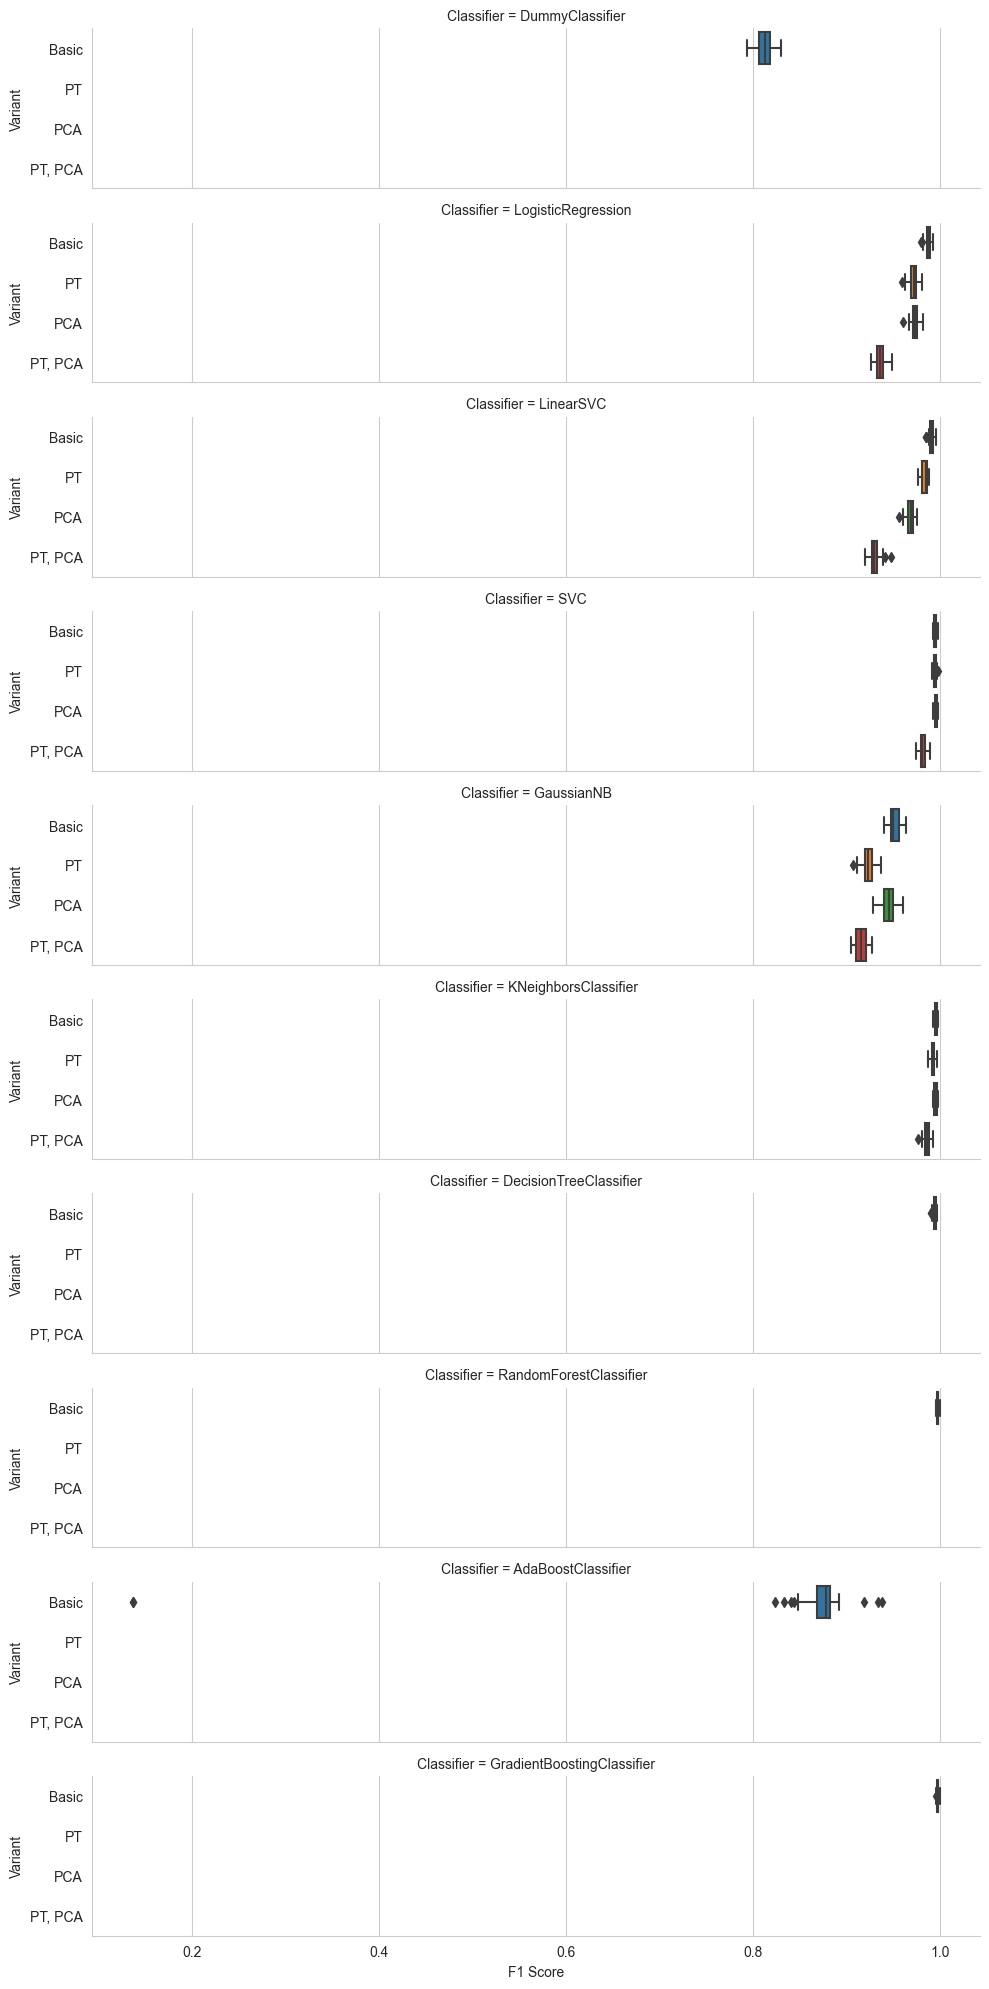

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

sns.catplot(
    data=model_results_df, 
    kind="box",
    x='F1 Score',
    y='Variant',
    row='Classifier',
    height=2,
    aspect=5,
    orient='h'
)